## Utils Testing

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
RAW_DATA_FILE = "resource/non-seasonal/df.csv"
SCALABILITY_FILE = "resource/non-seasonal/scalability_df.csv"
ADSTOCK_FILE = "resource/non-seasonal/adstock_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [4]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])
train_df = df[:-28]
test_df = df[-28:]
df.head(5)

,date,sales,promo,radio,search,social,tv
0,2019-01-01,888.00000,2003.00000,4779.00000,4603.00000,2123.00000,14120.00000
1,2019-01-02,978.00000,2210.00000,2676.00000,4028.00000,0.00000,7076.00000
2,2019-01-03,902.00000,0.00000,7219.00000,4037.00000,4000.00000,4118.00000
3,2019-01-04,904.00000,0.00000,7826.00000,3722.00000,0.00000,2926.00000
4,2019-01-05,972.00000,1076.00000,7877.00000,4353.00000,1771.00000,10259.00000


In [5]:
regressor_matrix = df.loc[:, paid_channels].values

### Testing Single Channel Adstock with CONV1D

torch.Size([5, 1, 1095])
torch.Size([1, 1, 28])
torch.Size([5, 1, 1068])


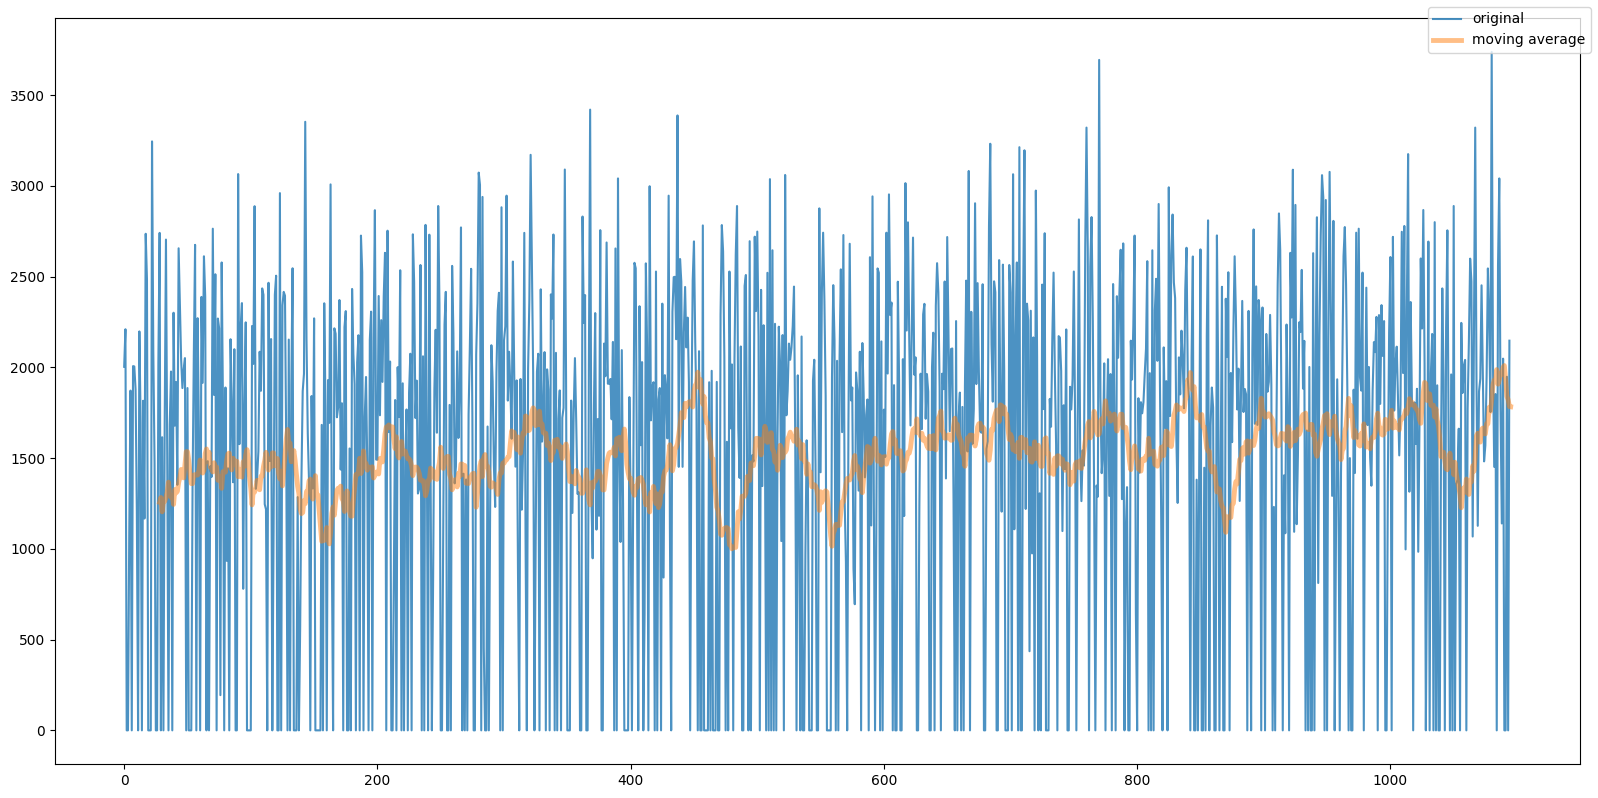

In [6]:
# get first channel; preserve shape
x = regressor_matrix[:, :1]
x = x.transpose(1, 0)
# duplicate  5 scenarios
x = np.tile(np.expand_dims(x, 0), (5, 1, 1))
x = torch.from_numpy(x)
print(x.shape)

# create a 28 days moving average window
ma_filter = np.ones((1, 28)) / 28
ma_filter = torch.from_numpy(np.flip(ma_filter, 1).copy())
ma_filter = ma_filter.unsqueeze(1)
print(ma_filter.shape)

ma_x = F.conv1d(x, ma_filter)
print(ma_x.shape)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(np.arange(x.shape[-1]), x[0, 0, ...], label="original", alpha=0.8)
ax.plot(
    np.arange(28, 28 + ma_x.shape[-1]),
    ma_x[0, 0, ...],
    label="moving average",
    alpha=0.5,
    lw=3.5,
)
# ax.plot(np.arange(28, 28 + len(lag_x)), lag_x, label='lag transformed', alpha=0.5)

fig.legend()
fig.tight_layout()

### Testing Multiple Channels Adstock with CONV1D

torch.Size([10, 5, 1095])
torch.Size([5, 1, 28])
torch.Size([10, 5, 1068])


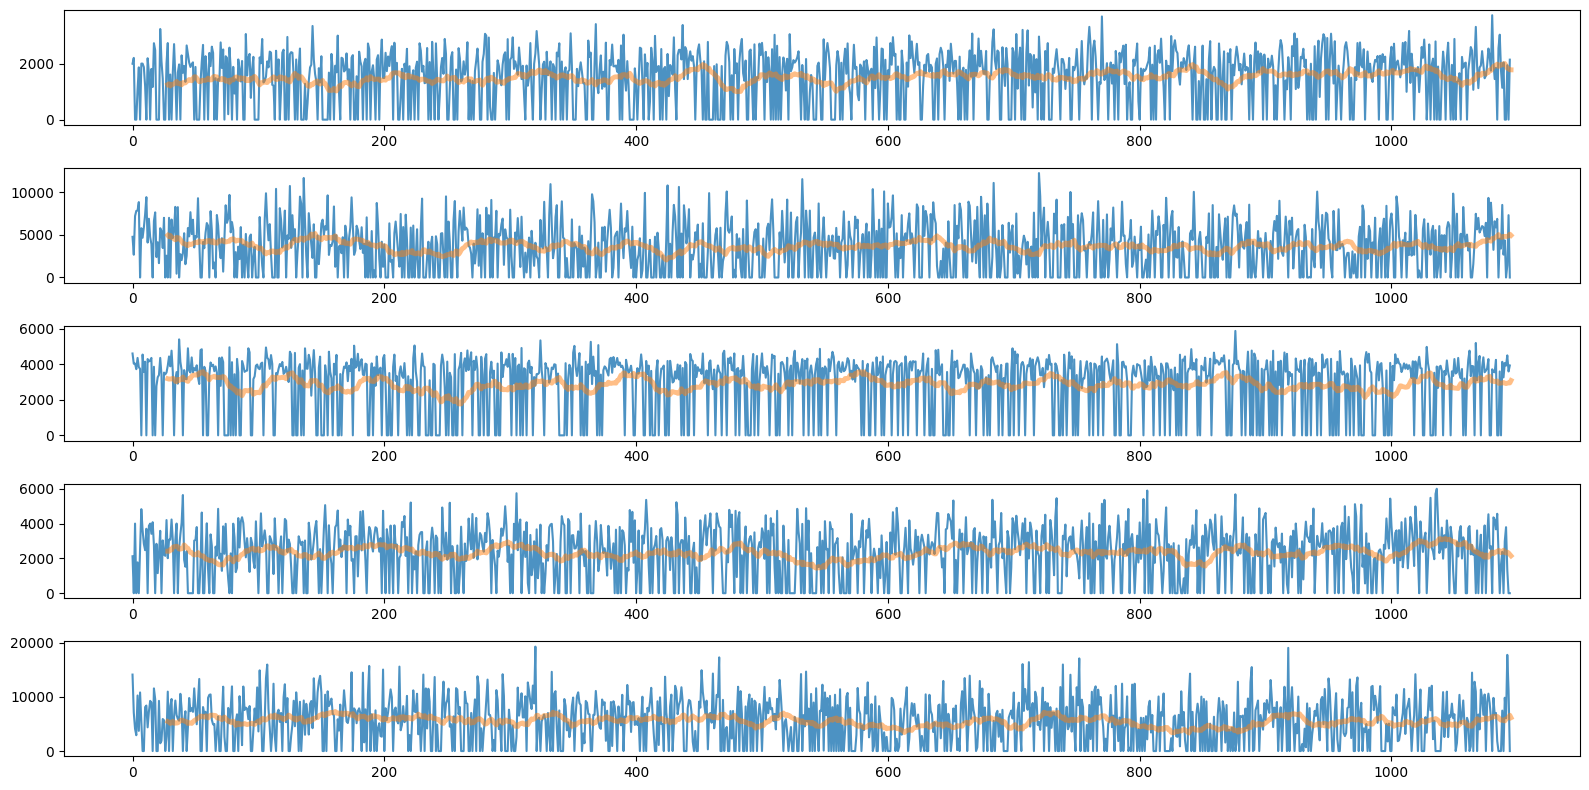

In [25]:
# get first channel; preserve shape
x = regressor_matrix
x = x.transpose(1, 0)
# duplicate 10 scenarios
x = np.tile(np.expand_dims(x, 0), (10, 1, 1))
x = torch.from_numpy(x)
print(x.shape)

# create a 28 days moving average window
ma_filter = np.ones((5, 1, 28)) / 28
ma_filter = torch.from_numpy(ma_filter)
# (n_regressors, 1, n_adstocks)
print(ma_filter.shape)

ma_x = F.conv1d(x, ma_filter, groups=5)
print(ma_x.shape)

fig, axes = plt.subplots(5, 1, figsize=(16, 8))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    ax.plot(np.arange(x.shape[-1]), x[0, idx, ...], label="original", alpha=0.8)
    ax.plot(
        np.arange(28, 28 + ma_x.shape[-1]),
        ma_x[0, idx, ...],
        label="moving average",
        alpha=0.5,
        lw=3.5,
    )
# ax.plot(np.arange(28, 28 + len(lag_x)), lag_x, label='lag transformed', alpha=0.5)

# fig.legend()
fig.tight_layout()

In [8]:
ma_x[0, idx, ...]

tensor([5462.0357, 5349.6786, 5096.9643,  ..., 6214.0714, 6613.8929,
        6156.9286], dtype=torch.float64)

In [9]:
ma_x[1, idx, ...]

tensor([5462.0357, 5349.6786, 5096.9643,  ..., 6214.0714, 6613.8929,
        6156.9286], dtype=torch.float64)

### Testing using Karpiu Directly for adstock

In [38]:
from karpiu.utils import adstock_process

In [50]:
x = regressor_matrix
# duplicate  10 scenarios
x = np.tile(np.expand_dims(x, 0), (10, 1, 1))
x.shape

(10, 1095, 5)

In [51]:
ma_filter = np.ones((5, 28)) / 28

the result here has a transpose of (-2, -1) comparing to previous block

In [56]:
ma_x = adstock_process(x, ma_filter)
print(ma_x.shape)

torch.Size([10, 5, 1095])
(10, 1068, 5)


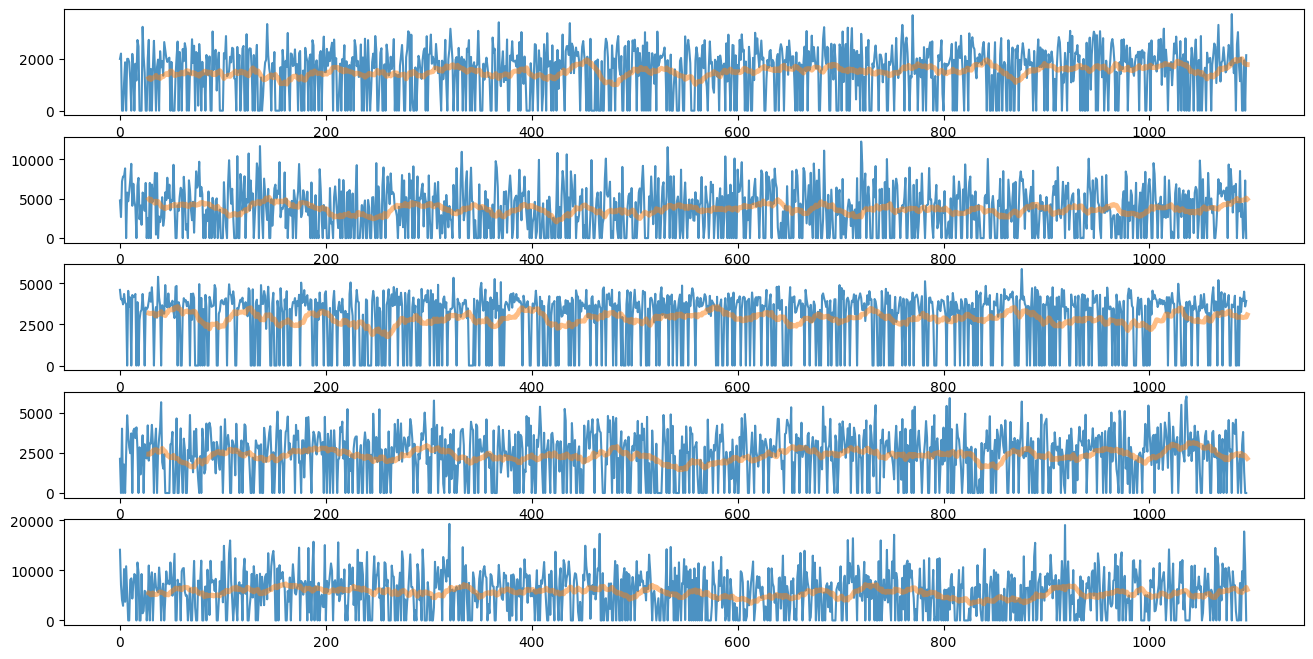

In [59]:
fig, axes = plt.subplots(5, 1, figsize=(16, 8))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    ax.plot(np.arange(x.shape[-2]), x[0, :, idx], label="original", alpha=0.8)
    ax.plot(
        np.arange(28, 28 + ma_x.shape[-2]),
        ma_x[0, :, idx],
        label="moving average",
        alpha=0.5,
        lw=3.5,
    )

### Testing using Karpiu Directly for adstock

In [38]:
from karpiu.utils import adstock_process

In [60]:
x = regressor_matrix
# single scanerios
x.shape

(1095, 5)

In [61]:
ma_filter = np.ones((5, 28)) / 28

the result here has a transpose of (-2, -1) comparing to previous block

In [62]:
ma_x = adstock_process(x, ma_filter)
print(ma_x.shape)

torch.Size([1, 5, 1095])
(1068, 5)


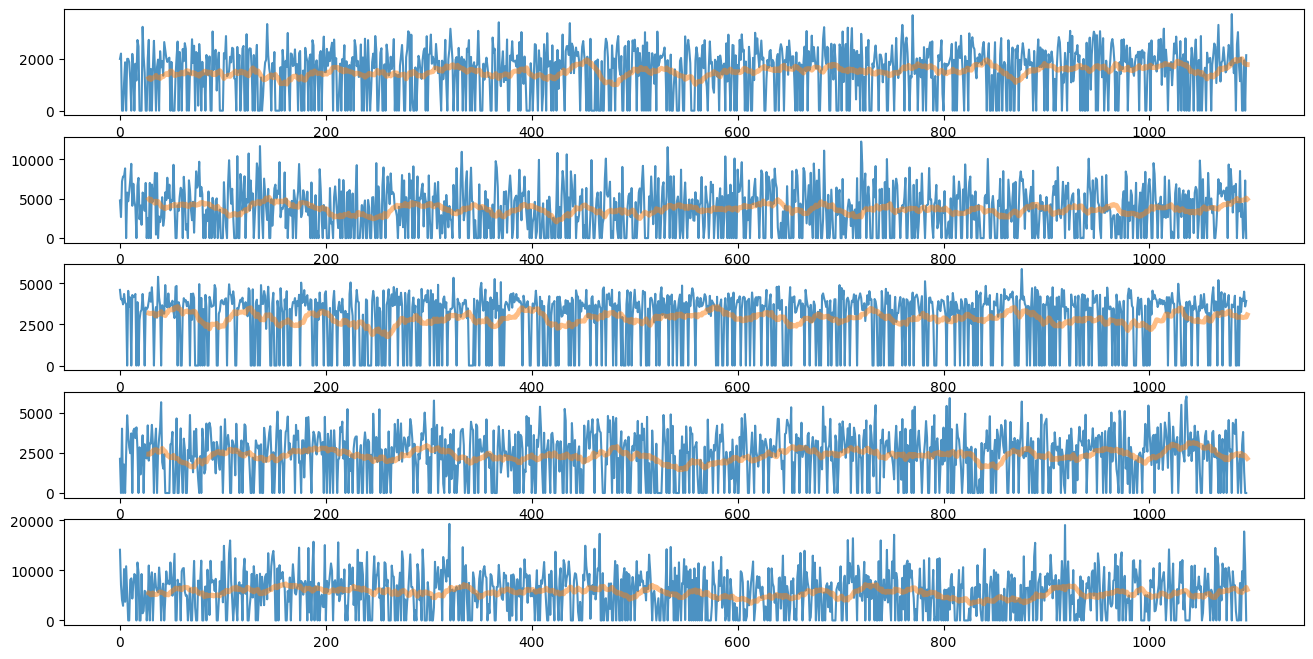

In [63]:
fig, axes = plt.subplots(5, 1, figsize=(16, 8))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    ax.plot(np.arange(x.shape[-2]), x[:, idx], label="original", alpha=0.8)
    ax.plot(
        np.arange(28, 28 + ma_x.shape[-2]),
        ma_x[:, idx],
        label="moving average",
        alpha=0.5,
        lw=3.5,
    )